See https://kaihsinwu.gitlab.io/Cytnx_doc/index.html for more information of the Cytnx library

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

In [1]:
import sys
import cytnx
import numpy as np
import matplotlib.pyplot as plt

MKL interface code: 1 >> using [ilp64] interface


# Density matrix renormalization group

## 1. Define the matrix product operator (MPO) for the Hamiltonian

### 1.1 Define operators

#### $$ \hat{S}^{+}=\left[\begin{array}{cc}
0 & 1\\
0 & 0
\end{array}\right]
, \qquad
\hat{S}^{-}=\left[\begin{array}{cc}
0 & 0\\
1 & 0
\end{array}\right]$$
#### $$ \hat{S}^{z}=\frac{1}{2}\left[\begin{array}{cc}
1 & 0\\
0 & -1
\end{array}\right]
, \qquad
\hat{S}^{x}=\frac{1}{2}\left[\begin{array}{cc}
0 & 1\\
1 & 0
\end{array}\right]
, \qquad
\hat{I}=\left[\begin{array}{cc}
1 & 0\\
0 & 1
\end{array}\right]
$$

<!-- ![alt text](szsx.png "Title") -->
<img src="figures/szsx.png" alt="drawing" width="300"/>

In [2]:
d = 2  # Physical dimension

# The operators are define in type <Tensor> (rather than <UniTensor>)
Sx = cytnx.physics.spin(0.5,'x').real()      # Sx
Sz = cytnx.physics.spin(0.5,'z').real()      # Sz
I = cytnx.eye(2)                               # Identity operator

# S+
Sp = cytnx.zeros([2,2])
Sp[0,1] = 1

# S-
Sm = cytnx.zeros([2,2])
Sm[1,0] = 1

### 1.2 Define Hamiltonian MPO

#### Transverse-field Ising model
#### $$\hat{H} = -\sum_{i=1}^{N-1} \hat{S}^x_i\hat{S}^x_{i+1} - h_z\sum_{i=1}^N \hat{S}^z_i$$
#### MPO tensor
#### $$\hat{H} = L_0 M_1 M_2 \cdots M_N R_0,$$
#### $$
L_{0}=\left[\begin{array}{ccc}
0 & 0 & 1\end{array}\right]
, \qquad
M_i=\left[\begin{array}{ccc}
\hat{I_i}\\
\hat{S}^{x}_i & 0\\
-h_{z}\hat{S}^{z}_i & -\hat{S}^{x}_i & \hat{I}_i
\end{array}\right]
, \qquad
R_{0}=\left[\begin{array}{c}
1\\
0\\
0
\end{array}\right]
$$

<img src="figures/mpo.png" alt="drawing" width="600"/>

In [3]:
dM = 3               # MPO bond dimension
def TFIM_MPO_tensor (hz, hx):
    M = cytnx.zeros([dM, dM, d, d])
    M[0,0] = I
    M[2,2] = I
    M[1,0] = Sx
    M[2,1] = -Sx
    M[2,0] = -hz*Sz - hx*Sx
    M = cytnx.UniTensor (M, rowrank=2)
    return M

L0 = cytnx.UniTensor (cytnx.zeros([dM,1,1]), rowrank=1)  # Left boundary
R0 = cytnx.UniTensor (cytnx.zeros([dM,1,1]), rowrank=1)  # Right boundary
L0.get_block_()[dM-1,0,0] = 1.
R0.get_block_()[0,0,0] = 1.

## 2. Initialize MPS

### 2.1 Initialize MPS as a product state
### $$ |\psi\rangle = |\uparrow\downarrow\uparrow\downarrow\cdots\uparrow\downarrow\rangle$$

<img src="figures/mps.png" alt="drawing" width="450"/>

In [11]:
# Initialize MPS as a product state
def get_init_MPS (Nsites):
    psi = [None for i in range(Nsites)]
    for i in range(Nsites):
        A = cytnx.zeros([1,d,1])
        spin = (i % 2)  # 0 for spin up and 1 for spin down
        A[0,spin,0] = 1
        #A[0,0,0] = 0.5**0.5
        #A[0,1,0] = 0.5**0.5
        psi[i] = cytnx.UniTensor (A, rowrank=2)
        psi[i].set_labels([str(2*i),str(2*i+1),str(2*i+2)])
    return psi

## 3. Define the effective Hamiltonian

### 3.1 Compute the environment tensors LR, and make the MPS **left orthogonal**

<img src="figures/leftotho.png" alt="drawing" width="700"/>
<img src="figures/envcontract.png" alt="drawing" width="400"/>

In [33]:
#LR[0]:        LR[1]:            LR[2]:
#
#   -----      -----A[0]---     -----A[1]---
#   |          |     |          |     |
#  ML----     LR[0]--M-----    LR[1]--M-----      ......
#   |          |     |          |     |
#   -----      -----A*[0]--     -----A*[1]--
#
#
def get_LR_envir_tensors (psi, M):
    Nsites = len(psi)

    LR = [None for i in range(Nsites+1)]
    LR[0]  = L0
    LR[-1] = R0

    anet = cytnx.Network()
    anet.FromString(["L: -2,-1,-3",
                     "A: -1,-4,1",
                     "M: -2,0,-4,-5",
                     "Aconj: -3,-5,2",
                     "TOUT: 0;1,2"])
    for p in range(Nsites - 1):
        
        # Make A[p] left orthogonal
        s, u, vt = cytnx.linalg.Svd(psi[p])

        # Setting psi[p] = u
        psi[p].put_block(u.get_block())
        
        # Put the orthogonality center to the right site
        r = cytnx.Contract (s, vt)
        psi[p+1].put_block(cytnx.Contract (r, psi[p+1]).get_block())
        
        # Compute the left boundary tensor on site p
        anet.PutUniTensors (["L","A","Aconj","M"], [LR[p],psi[p],psi[p].Conj(),M])
        LR[p+1] = anet.Launch()
    return LR

### 3.2 Define effective Hamiltonian and $\hat{H}|\psi\rangle$ operation

<img src="figures/heff.png" alt="drawing" width="600"/>

In [48]:
# An effective Hamiltonian must:
# 1. Inherit <cytnx.LinOp> class
# 2. Has a function <matvec> that implements H|psi> operation

class eff_Hamilt (cytnx.LinOp):
    def __init__ (self, L, M1, M2, R):
        # Initialization
        cytnx.LinOp.__init__(self,"mv", 0)

        # Define network for H|psi> operation
        anet = cytnx.Network()
        anet.FromString(["psi: -1,-2,-3,-4",
                         "L: -5,-1,0",
                         "R: -7,-4,3",
                         "M1: -5,-6,-2,1",
                         "M2: -6,-7,-3,2",
                         "TOUT: 0,1;2,3"])
        anet.PutUniTensors(["L","M1","M2","R"],[L,M1,M2,R])
        self.anet = anet

    # Define H|psi> operation
    def matvec (self, v):
        lbl = v.labels(); 
        self.anet.PutUniTensor("psi",v);
        out = self.anet.Launch()
        out.set_labels(lbl);   # Make sure the input label match output label
        return out

## 4. Find the ground state by DMRG

### 4.1 DMRG algorithm

<img src="figures/dmrg_sweep.png" alt="drawing" width="600"/>
<img src="figures/twositecontract.png" alt="drawing" width="650"/>

In [63]:
from scipy.sparse.linalg import LinearOperator, eigsh, eigs

# Optimize phi using Scipy function (Not used)
def optimize_psi_scipy(psivec, L, M1, M2, R):
    
    lbl=psivec.labels()
    pshape = [L.shape()[1],M1.shape()[2],M2.shape()[2],R.shape()[1]]
    
    effH = eff_Hamilt (L, M1, M2, R)
    def linop (vec):
        vec = vec.reshape(pshape)
        vec = cytnx.UniTensor(cytnx.from_numpy(vec), rowrank = 2)
        vec = effH.matvec (vec)
        return vec.get_block().numpy().flatten()

    dim = L.shape()[1] * M1.shape()[2] * M2.shape()[2] * R.shape()[1]
    TensorOp = LinearOperator ((dim, dim), matvec=linop, dtype=np.float64)
    energy, psivec = eigsh (TensorOp, k=1, which='SA', v0=psivec.get_block().numpy().flatten(),
                            ncv=None, maxiter=2, tol=1e-2)
    psivec = cytnx.UniTensor(cytnx.from_numpy(psivec.reshape(pshape)))
    psivec.set_labels(lbl)
    
    return psivec, energy

def dmrg (psi, M, maxdims, cutoff):
    # Define the network for computing the environment tensors
    # Network for computing right environment tensors
    R_env_net = cytnx.Network()
    R_env_net.FromString(["R: -2,-1,-3",
                          "B: 1,-4,-1",
                          "M: 0,-2,-4,-5",
                          "B_Conj: 2,-5,-3",
                          "TOUT: 0;1,2"])
    # Network for computing left environment tensors
    L_env_net = cytnx.Network()
    L_env_net.FromString(["L: -2,-1,-3",\
                          "A: -1,-4,1",\
                          "M: -2,0,-4,-5",\
                          "A_Conj: -3,-5,2",\
                          "TOUT: 0;1,2"])
    anets = [R_env_net, L_env_net]



    # Define the links to update for a sweep
    # First do a right-to-left and then a left-to-right sweep
    ranges = [range(Nsites-2,-1,-1), range(Nsites-1)]

    # For printing information
    verbose = ["[r->l]", "[l->r]"]


    # Get the environment tensors
    LR = get_LR_envir_tensors (psi, M)
    
    ens = []
    for k in range(len(maxdims)):                                                            # For each sweep
        chi = maxdims[k]                                                                     # Read bond dimension
        print ('Sweep',k,', chi='+str(chi))
        for lr in [0,1]:
            for p in ranges[lr]:                                                                # For each bond
                # Compute the current psi
                phi = cytnx.Contract (psi[p], psi[p+1])
                phi.set_rowrank(2);
                
                # Define the effective Hamiltonian
                effH = eff_Hamilt (LR[p], M, M, LR[p+2])

                # Find the ground state for the current bond
                enT, phi = cytnx.linalg.Lanczos(effH, phi, method = "Gnd", CvgCrit=999, Maxiter=2)
                en = enT.item()                                                                 # Tensor to number
                
                # phi, en = optimize_psi_scipy (phi, LR[p], M, M, LR[p+2])
                
                # Store the energy
                ens.append(en);

                # SVD and truncate the wavefunction psi
                # s, psi[p], psi[p+1] = cytnx.linalg.Svd_truncate (phi, keepdim=chi, err=cutoff)

                s, u, vt = cytnx.linalg.Svd_truncate(phi, keepdim=chi, err=cutoff)      

                # Save labels of psi[p] and psi[p+1] for later use
                lbl1 = psi[p].labels()
                lbl2 = psi[p+1].labels()
                
                # Setting psi[p] = u, psi[p+1] = vt
                psi[p] = u
                psi[p+1] = vt
                
                # Normalize the singular values
                s = s/s.get_block_().Norm().item()

                if lr == 0:
                    # Absorb s into next neighbor
                    psi[p] = cytnx.Contract(psi[p],s)

                    # Set the network for the right environment tensor on the current site
                    anets[lr].PutUniTensors(["R","B","M","B_Conj"],[LR[p+2],psi[p+1],M,psi[p+1].Conj()])                
                if lr == 1:
                    # Absorb s into next neighbor
                    psi[p+1] = cytnx.Contract(s,psi[p+1])
                    # Set the network for the left environment tensor on the current site
                    anets[lr].PutUniTensors(["L","A","A_Conj","M"],[LR[p],psi[p],psi[p].Conj(),M])
                    
                psi[p].set_labels(lbl1)
                psi[p+1].set_labels(lbl2)
                # Compute and save the environment tensor on the current site
                LR[p+1] = anets[lr].Launch()
                
            print ('\t',verbose[lr],'energy =',en)
    return psi

### 4.2 Find the ground state

In [64]:
Nsites = 20       # Number of sites

# Get MPO tensor
hz = 0.1          # Transverse field
hx = 1e-8            # Longitudinal field
M = TFIM_MPO_tensor (hz, hx)       # Make MPO tensor

# Get initial state MPS
psi = get_init_MPS (Nsites)

# Define the bond dimensions for the sweeps
maxdims = [8,16,32,64,128]
cutoff = 1e-12

# Run dmrg!!
psi = dmrg (psi, M, maxdims, cutoff)

print ('Ground state energy for hz=0.1 is ~ -4.805151652932')

Sweep 0 , chi=8
	 [r->l] energy = -4.677035882069475
	 [l->r] energy = -4.804469213722561
Sweep 1 , chi=16
	 [r->l] energy = -4.805131210889346
	 [l->r] energy = -4.805151111016484
Sweep 2 , chi=32
	 [r->l] energy = -4.8051515920511205
	 [l->r] energy = -4.805151646048013
Sweep 3 , chi=64
	 [r->l] energy = -4.805151652062929
	 [l->r] energy = -4.805151652838503
Sweep 4 , chi=128
	 [r->l] energy = -4.805151652926001
	 [l->r] energy = -4.8051516529351295
Ground state energy for hz=0.1 is ~ -4.805151652932


## 5. Measure $\langle S_z\rangle$, $\langle S_x\rangle$, and the entanglement entropy


### 5.1 Define the measurement functions

<img src="figures/szmea.png" alt="drawing" width="400"/>

#### Entanglement entropy
#### $$ S_A = -\mathrm{Tr}\left(\hat{\rho}_A \log \hat{\rho}_A\right),$$
#### where $\hat{\rho}_A$ is the reduced density matrix of subsystem A.

In [10]:
def measure (MPS):
    def mea_op (A, op):
        anet = cytnx.Network()
        anet.FromString(["A: 1;2,3",
                         "Op: 2;4",
                         "A_Conj: 1;4,3",
                         "TOUT:;"])
        anet.PutUniTensors (["Op","A","A_Conj"],[op, A, A.Conj()])
        return anet.Launch().item()

    N = len(MPS)
    Sz_ = cytnx.UniTensor (Sz, rowrank=1)
    Sx_ = cytnx.UniTensor (Sx, rowrank=1)

    psi = MPS.copy()
    Ss = np.full (N-1, np.nan)
    szs = np.full (N, np.nan)
    sxs = np.full (N, np.nan)

    for p in range(Nsites-2,-1,-1):
        psi[p+1].set_rowrank(1)
        # Measure Sz
        szs[p+1] = mea_op (psi[p+1], Sz_)
        sxs[p+1] = mea_op (psi[p+1], Sx_)

        # Move the orthogonality center to the left site
        s, u, vt = cytnx.linalg.Svd (psi[p+1])
        psi[p].put_block(cytnx.Contract (psi[p], cytnx.Contract(u, s)).get_block())

        # Measure the entanglement entropy
        S = 0
        for si in s.get_block_():
            rhoi = si.item()**2
            S += -rhoi * np.log(rhoi)
        Ss[p] = S
    psi[0].set_rowrank(1)
    szs[0] = mea_op (psi[0], Sz_)
    sxs[0] = mea_op (psi[0], Sx_)

    return szs, sxs, Ss

### 5.2 Do the measurements and plot the results

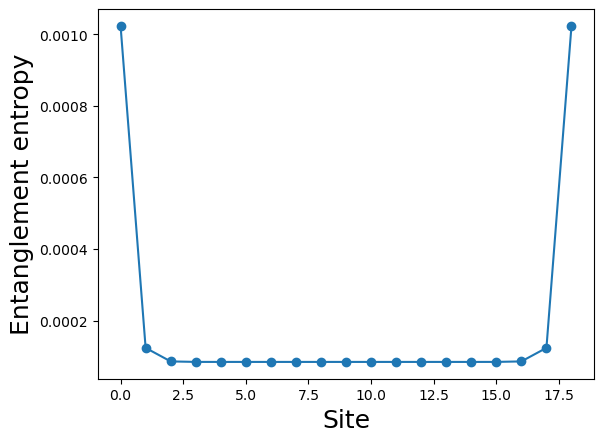

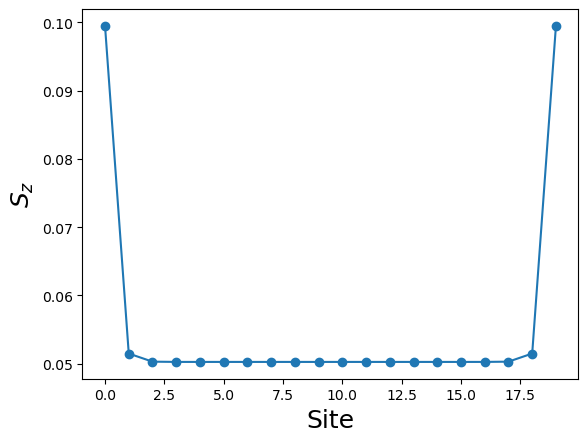

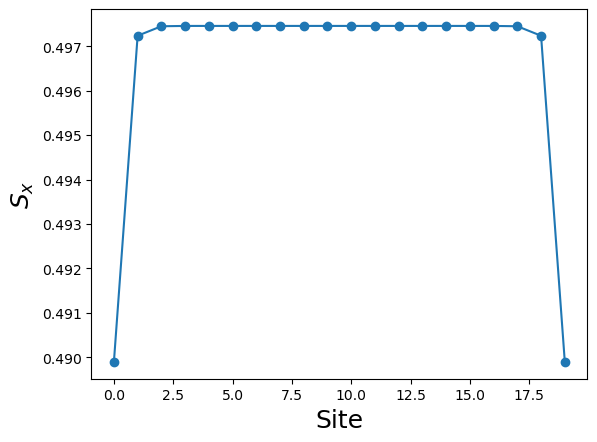

In [11]:
szs, sxs, Ss = measure (psi)

f,ax = plt.subplots()
ax.plot (range(len(Ss)), Ss, marker='o')
ax.set_xlabel('Site', fontsize=18)
ax.set_ylabel('Entanglement entropy', fontsize=18)

f,ax = plt.subplots()
ax.plot (range(len(szs)), szs, marker='o')
ax.set_xlabel('Site', fontsize=18)
ax.set_ylabel ('$S_z$', fontsize=18)

f,ax = plt.subplots()
ax.plot (range(len(sxs)), sxs, marker='o')
ax.set_xlabel('Site', fontsize=18)
ax.set_ylabel ('$S_x$', fontsize=18)
plt.show()

## Homework 1.
In the example above we've study the traverse field Ising model at small $h_z$, and find $\langle S_z \rangle = 0 $ and $\langle S_x \rangle = 0.5 $, how about at **large** $h_z$ like $h_z = 2$ ? Can you find the **transition point** ?

## Homework 2.
Find the ground state energy of the **XX model** given by the Hamiltonian:

$$\hat{H} = \sum_{i=1}^{N-1} -\hat{S}^x_i\hat{S}^x_{i+1} -  \hat{S}^y_i\hat{S}^y_{i+1}$$

You can use the following function to get the exact value given the desired system size $N$, use it to **benchmark** your DRMG result with $N=16, 32,100$

In [ ]:
def getXXexact(N):
    import numpy as np
    H = np.diag(np.ones(N-1),k=1) + np.diag(np.ones(N-1),k=-1)
    D = LA.eigvalsh(H)
    EnExact = 2*sum(D[D < 0])
    return EnExact


## Homework 3.
Find the ground state energy of the **antiferromagnet Heisenberg model** given by the Hamiltonian:

$$\hat{H} = \sum_{i=1}^{N-1} \hat{S}^x_i\hat{S}^x_{i+1} + \hat{S}^y_i\hat{S}^y_{i+1} + \hat{S}^z_i\hat{S}^z_{i+1}$$

Please try several values of $N$ and **extraplolated** to $N \to \infty$ and compare to the exact value at **thermaldynamic limit**:
$$1/4 - log(2) \approx -0.4431$$